## Initial Imports and Paths

In [1]:
import pandas as pd
import numpy as np
import os
# midi files
import mido

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# ml packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# file paths
train_midi_path = "./Challenge_DataSet/PS1/"
test_midi_path = "./Challenge_DataSet/PS2/"

print(os.listdir(train_midi_path))
print(os.listdir(test_midi_path))

['.DS_Store', 'Beethoven', 'Schubert', 'Bach', 'Brahms']
['0.8014751784512073_adj.mid', '0.981087291054314_adj.mid', '0.5807329043589801_adj.mid', '0.23120017256495873_adj.mid', '0.033313986422223163_adj.mid', '0.3559970176888735_adj.mid', '0.3264565808984162_adj.mid', '0.905499891236923_adj.mid', '0.10250888365879718_adj.mid', '0.48367685897240176_adj.mid', '0.549470161204349_adj.mid', '0.33695573887576447_adj.mid', '0.7491289879531658_adj.mid', '0.337517805339117_adj.mid', '0.07186746659481313_adj.mid', '0.09167358800381353_adj.mid', '0.539512676743813_adj.mid', '0.26551079719260606_adj.mid', '0.647959423719129_adj.mid', '0.047574444458241216_adj.mid', '0.10222964826466285_adj.mid', '0.22047111832936942_adj.mid', '0.1755252422917658_adj.mid', '0.36321860283443286_adj.mid', '0.21198476749665085_adj.mid', '0.06402123326764841_adj.mid', '0.3620067189216978_adj.mid', '0.9511403301279795_adj.mid', '0.1960551158929671_adj.mid', '0.21901852969811753_adj.mid', '0.10630249969742178_adj.mid', 

## Data Collection and Processing

In [3]:
def extract_features_from_midi(file_path):
    ## Input: file path of midi file
    ## Output: list [ticks per beat, key, average_velocity, note counts for 128 notes]

    # import file
    midi = mido.MidiFile(file_path)

    # initialize values
    note_counts = [0] * 128  # MIDI notes range from 0 to 127
    total_velocity = 0
    note_on_count = 0
    key = '' # each file should have only 1 key. Investigate if this assumption is correct.
    tpb = midi.ticks_per_beat

    # get ticks
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                note_counts[msg.note] += 1
                total_velocity += msg.velocity
                note_on_count += 1
            if msg.is_meta and msg.type == 'key_signature':
                key = msg.key
            
    # Calculate average velocity
    if note_on_count > 0:
        average_velocity = total_velocity / note_on_count
    else:
        average_velocity = 0
    
    # Normalize the note counts to be between 0 and 1
    normalized_note_counts = (note_counts - np.min(note_counts)) / (np.max(note_counts) - np.min(note_counts))
    
    # combine into 1 list
    combined_features = [tpb, key, average_velocity] + list(normalized_note_counts)

    return combined_features

In [4]:
def load_dataset(directory):
    features = []
    labels = []
    for composer_dir in os.listdir(directory):
        composer_path = os.path.join(directory, composer_dir)
        if os.path.isdir(composer_path):
            for file_name in os.listdir(composer_path):
                if file_name.endswith('.mid'):
                    file_path = os.path.join(composer_path, file_name)
                    features.append(extract_features_from_midi(file_path))
                    labels.append(composer_dir)
    return features, labels

In [6]:
features, labels = load_dataset(train_midi_path)

## EDA

In [7]:
def create_dataframe(features, labels):
    # Convert to pandas DataFrame
    feature_columns = ['tpb', 'key', 'average_velocity']+[f'Note_{i}' for i in range(128)]
    df = pd.DataFrame(features, columns=feature_columns)
    df['Composer'] = labels
    return df

df_labeled = create_dataframe(features, labels)
df_labeled.to_csv('eda_df.csv')
df_labeled.head()

,tpb,key,average_velocity,Note_0,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,...,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127,Composer
0,384,Cm,101.945073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
1,384,Dm,94.358557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
2,384,Eb,82.289295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
3,384,Cm,85.691959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
4,384,G,86.643597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven


In [8]:
# Display basic information about the DataFrame
print("\nBasic Information about the DataFrame:")
print(df_labeled.info())

# Generate summary statistics
print("\nSummary Statistics of the DataFrame:")
print(df_labeled.describe())

# Check for missing values
print("\nMissing Values in the DataFrame:")
print(df_labeled.isnull().sum())


Basic Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Columns: 132 entries, tpb to Composer
dtypes: float64(129), int64(1), object(2)
memory usage: 200.2+ KB
None

Summary Statistics of the DataFrame:
               tpb  average_velocity  Note_0  Note_1  Note_2  Note_3  Note_4  \
count   194.000000        194.000000   194.0   194.0   194.0   194.0   194.0   
mean    349.567010         82.246621     0.0     0.0     0.0     0.0     0.0   
std     129.871112         13.565164     0.0     0.0     0.0     0.0     0.0   
min     120.000000         46.818713     0.0     0.0     0.0     0.0     0.0   
25%     384.000000         73.121036     0.0     0.0     0.0     0.0     0.0   
50%     384.000000         83.024333     0.0     0.0     0.0     0.0     0.0   
75%     384.000000         92.797942     0.0     0.0     0.0     0.0     0.0   
max    1024.000000        127.000000     0.0     0.0     0.0     0.0     0.0   

       Note_5  Note_

In [9]:
df_labeled.key.value_counts()

key
C      28
Eb     26
       16
G      15
F      15
Ab     15
Bb     14
E      14
A      12
D      10
Cm      8
Fm      5
Dm      4
Bm      3
Am      2
Db      2
Gm      1
Em      1
Abm     1
F#      1
Gb      1
Name: count, dtype: int64

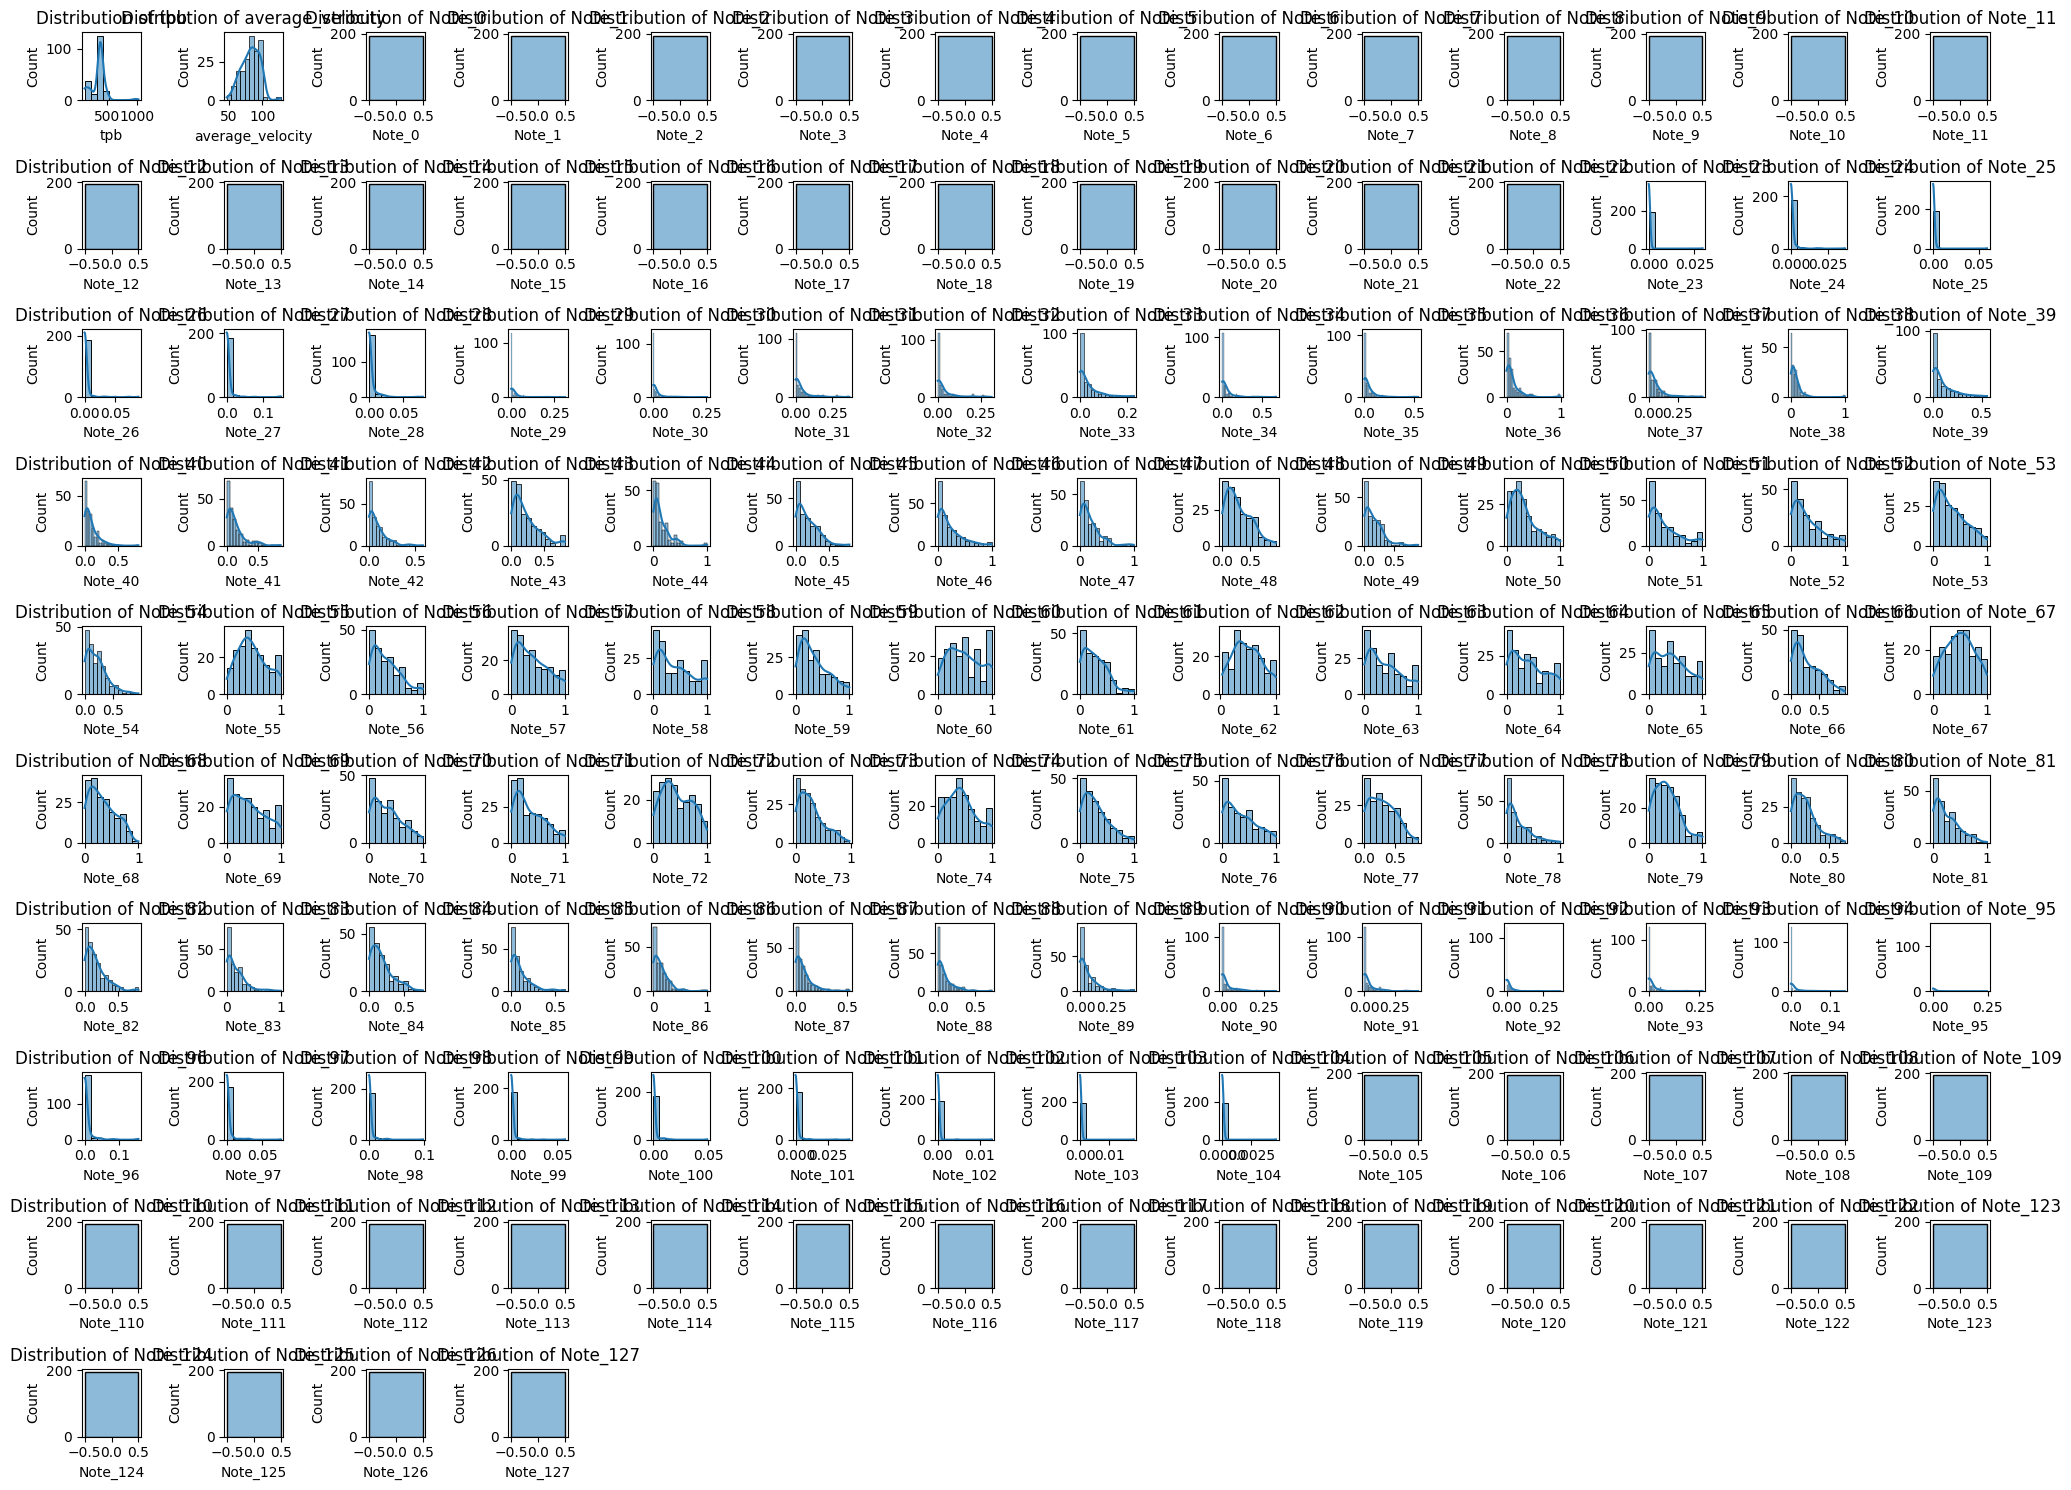

In [10]:
# Visualize the distribution of each numeric feature
numeric_columns = df_labeled.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_labeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

based on this, I'd remove notes 0-22, 105-127, unless we want to add back in for novelty detection

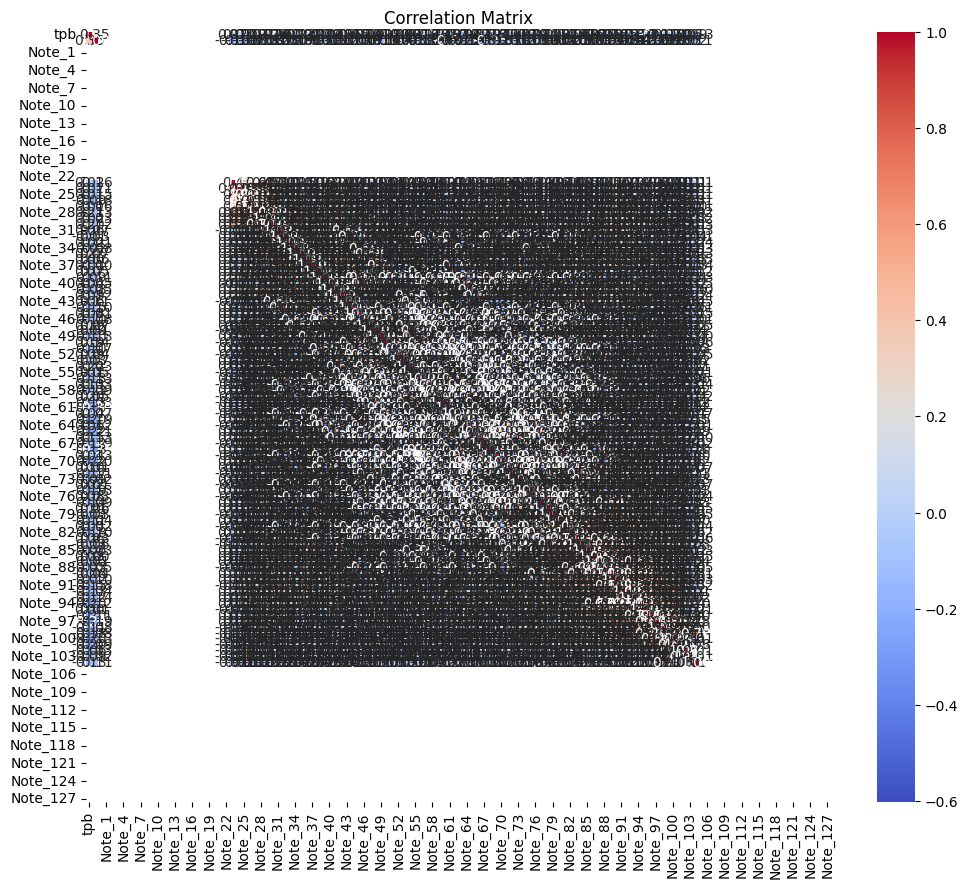

In [11]:
# Visualize correlations between numeric features
plt.figure(figsize=(12, 10))
correlation_matrix = df_labeled[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

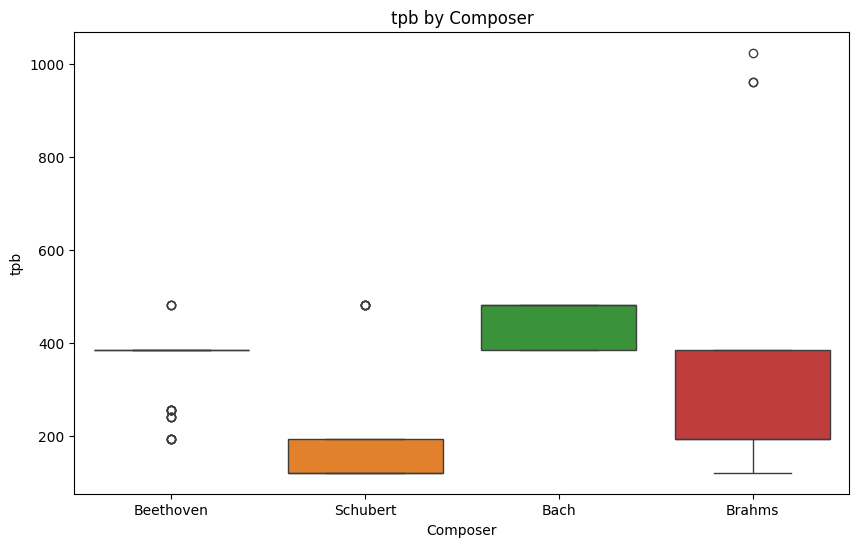

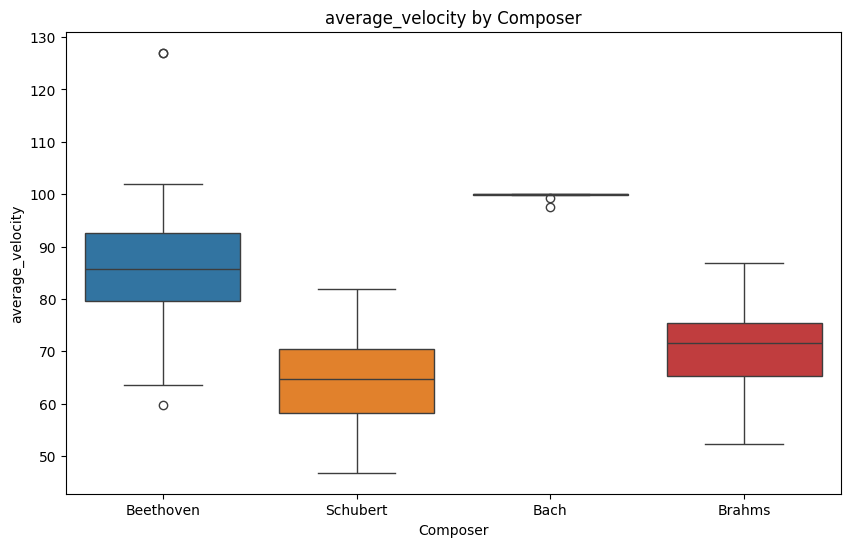

In [12]:
# Visualize the relationship between the first two numeric features and the target (if applicable)
if 'Composer' in df_labeled.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Composer', y=numeric_columns[0], data=df_labeled, hue='Composer')
    plt.title(f'{numeric_columns[0]} by Composer')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Composer', y=numeric_columns[1], data=df_labeled, hue='Composer')
    plt.title(f'{numeric_columns[1]} by Composer')
    plt.show()

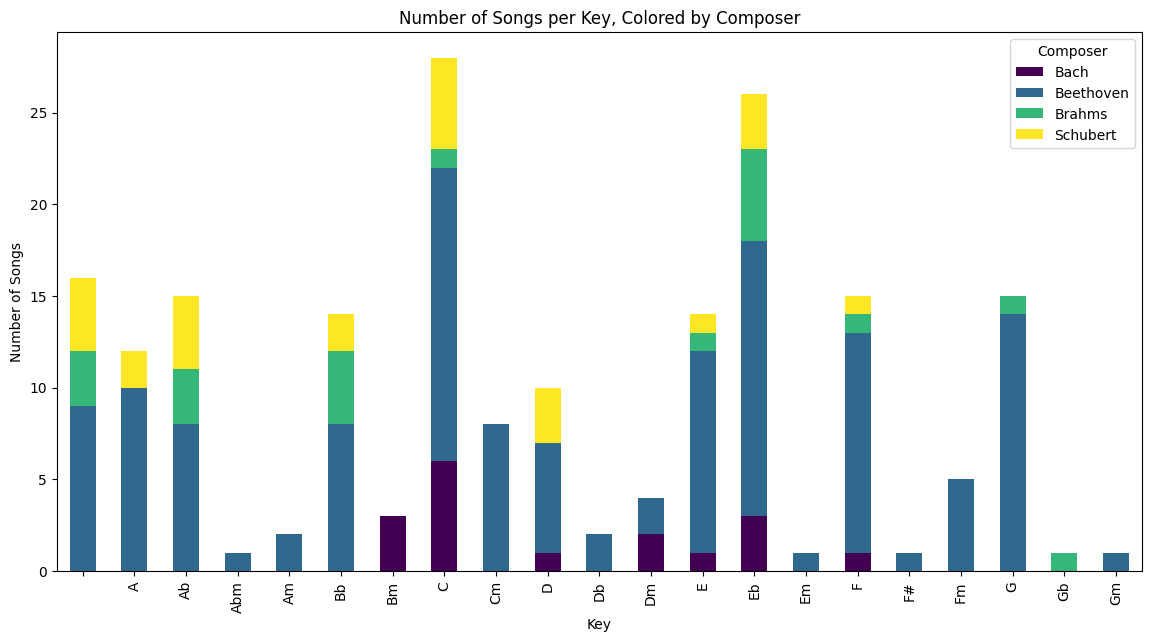

In [13]:
# Prepare the data for the stacked bar chart
key_composer_counts = df_labeled.groupby(['key', 'Composer']).size().unstack(fill_value=0)
# Plot the stacked bar chart
key_composer_counts.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Number of Songs per Key, Colored by Composer')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.legend(title='Composer')
plt.show()


In [ ]:
# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(composer_avg, cmap='viridis', cbar=True)

# Display the plot
plt.title('Composer Note Values Heatmap')
plt.xlabel('Notes')
plt.ylabel('Composers')
plt.show()

In [ ]:
# Transform the DataFrame into a long format
df_long = pd.melt(composer_avg.reset_index(), id_vars=['Composer'], var_name='Note', value_name='Value')

# Plot the bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x='Note', y='Value', hue='Composer', data=df_long)

# Customize the plot
plt.title('Composer Note Values Bar Chart')
plt.xlabel('Notes')
plt.ylabel('Values')
plt.legend(title='Composer')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better readability

# Display the plot
plt.show()

## Feature engineer/Bart

In [14]:
# Drop rows with missing values in 'key' as it's a categorical variable
# * come back and make this an encoded variable
df_labeled.dropna(subset=['key'], inplace=True)

In [15]:
# Encode the 'key' variable
label_encoder_key = LabelEncoder()
df_labeled['key_encoded'] = label_encoder_key.fit_transform(df_labeled['key'])

In [16]:
# Define the features (X) and target (y)
X = df_labeled.drop(columns=['Composer', 'key'])
y = df_labeled['Composer']

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [18]:
print('train targets\n',y_train.value_counts())
print('\ntest targets\n',y_test.value_counts())

train targets
 Composer
Beethoven    77
Schubert     16
Brahms       15
Bach          8
Name: count, dtype: int64

test targets
 Composer
Beethoven    55
Schubert      9
Bach          9
Brahms        5
Name: count, dtype: int64


## Train Classifier

### Logistic Regression

In [20]:
# Train and evaluate the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

/Users/bartmasters/code/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
print("Logistic Regression:")
print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr,))

Logistic Regression:
Accuracy Score: 0.8333333333333334

Classification Report:
              precision    recall  f1-score   support

        Bach       0.83      0.56      0.67         9
   Beethoven       0.88      0.93      0.90        55
      Brahms       0.67      0.40      0.50         5
    Schubert       0.64      0.78      0.70         9

    accuracy                           0.83        78
   macro avg       0.75      0.67      0.69        78
weighted avg       0.83      0.83      0.83        78



### Random Forest

In [22]:
# Build and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Predict the target on the test set
y_pred = rf_classifier.predict(X_test)

In [24]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score: 0.8717948717948718

Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      0.78      0.88         9
   Beethoven       0.89      1.00      0.94        55
      Brahms       0.00      0.00      0.00         5
    Schubert       0.75      0.67      0.71         9

    accuracy                           0.87        78
   macro avg       0.66      0.61      0.63        78
weighted avg       0.83      0.87      0.85        78



## Inference

In [ ]:
def predict_composer(file_path, classifier):
    features = extract_features_from_midi(file_path)
    prediction = classifier.predict([features])
    return prediction[0]

# Example usage
new_midi_file = 'new_piece.mid'
composer = predict_composer(new_midi_file, clf)
print(f"The predicted composer is: {composer}")
